# Описание проекта
Клиентам компании «Мегалайн» предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
    
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Задача
Проверить гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

# Импорт библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None) # Убираем ограничение с ширины отображаемой таблицы
import math
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np

# Первичный осмотр

**Описание данных:**

*Таблица users (информация о пользователях):*
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

*Таблица calls (информация о звонках):*
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

*Таблица messages (информация о сообщениях):*
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

*Таблица internet (информация об интернет-сессиях):*
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

*Таблица tariffs (информация о тарифах):*
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Прочитаем таблицы, и посмотрим их краткое описание с помощью функций `info()` и `describe()`.

In [2]:
calls = pd.read_csv('calls.csv')
calls.name = 'Calls'
internet = pd.read_csv('internet.csv')
internet.name = 'Internet'
messages = pd.read_csv('messages.csv')
messages.name = 'Messages'
tariffs = pd.read_csv('tariffs.csv')
tariffs.name = 'Tariffs'
users = pd.read_csv('users.csv')
users.name = 'Users'

In [3]:
frames = [calls, internet, messages, tariffs, users] #Создадим список со всеми таблицами.
for frame in frames:
    print('\t***' + frame.name + '***')
    print(frame.info())
    print(frame.describe())
    display(frame.head(5))
    print()

	***Calls***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



	***Internet***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
          Unnamed: 0        mb_used        user_id
count  149396.000000  149396.000000  149396.000000
mean    74697.500000     370.192426    1252.099842
std     43127.054745     278.300951     144.050823
min         0.000000       0.000000    1000.000000
25%     37348.750000     138.187500    1130.000000
50%     74697.500000     348.015000    1251.000000
75%    112046.250000     559.552500    1380.000000
max    149395.000000    1724.830000    1499.000000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



	***Messages***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
             user_id
count  123036.000000
mean     1256.989410
std       143.523967
min      1000.000000
25%      1134.000000
50%      1271.000000
75%      1381.000000
max      1499.000000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



	***Tariffs***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None
       messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       1767.766953   
min            50.000000           153

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



	***Users***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
           user_id        age
count   500.000000  500.00000
mean   1249.500000   46.58800
std     144.481833   16.66763
min    1000.000000   18.00000
25%    1124.750000   32.00000
50%    1249.500000   46.00000
75%    1374.250000   62.00000
max    1499.000000   75.00000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


**Calls** - всё в пределах нормы. Пустых значений нет. *call_date* стоит перевести в тип `datetime`.

**Internet** - лишний столбец *Unnamed: 0*. Остальные столбцы в пределах нормы. Пустых значений нет. *session_date* стоит перевести в тип `datetime`.

**Messages** - всё в пределах нормы. Пустых значений нет. *message_date* стоит перевести в тип `datetime`.

**Tariffs** - суперкороткая таблица с описанием тарифов.

**Users** -  всё в пределах нормы. Пустые значения соответсвуют описанию. *churn_date* и *reg_date* стоит перевести в тип `datetime`.

# Предобработка
Из описания таблицы **Internet** видно, что там появился один лишний столбец **Unnamed: 0**, который полностью повторяет значения `internet.index`. Если отрыть файл internet.csv, то можно увидеть, что это произошло из-за лишней запятой в начале файла. Этот столбец неиформативен и можно его спокойно удалить.

In [4]:
internet.drop('Unnamed: 0' ,axis='columns', inplace=True)

Для дальнейшего удобства приведем все даты в таблицах к типу datetime.

In [5]:
for frame in frames:
    for column in frame.columns:
        if 'date' in column:
            frame[column] = pd.to_datetime(frame[column], format='%Y-%m-%d')

В таблице **Calls** округлим минуты в большую сторону.

In [6]:
calls['duration'] = np.ceil(calls['duration'])

Оценим количество нулевых значений среди звонков и интернет-трафика.

In [7]:
calls.query('duration == 0').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39613 entries, 0 to 202596
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         39613 non-null  object        
 1   call_date  39613 non-null  datetime64[ns]
 2   duration   39613 non-null  float64       
 3   user_id    39613 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [8]:
internet.query('mb_used == 0').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19598 entries, 11 to 149393
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            19598 non-null  object        
 1   mb_used       19598 non-null  float64       
 2   session_date  19598 non-null  datetime64[ns]
 3   user_id       19598 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 765.5+ KB


Можно заметить, что нулевых значений среди продолжительностей звонков и количества использованного трафика довольно много, и по сути их можно было бы почти* спокойно дропнуть. Но поскольку в дальнейшем все эти значения суммируются по месяцам, то они на конечный результат не повлияют. В дальнейшем все равно будет использоваться скомпанованная таблица *total_usage*.

Что касается возникновения таких значений. То нулевые звонки - это сброшенные или прорущенные. А нулевой трафик - это, например, тот трафик который не засчитывается (мессенджеры, соцсети).   

**в теории может существовать месяц в котором все звонки были длиной в 0, интернета было использовано 0 и не было отправлено сообщений. И если убрать такой месяц, то он пропадет из финальной таблицы. Но абонентская плата ведь за такой месяц все равно берется. Так что это могло бы сделать датасет беднее.*

# Расчеты
Для дальнейшего удобства добавим в таблицы **Calls**, **Internet** и **Messages** столбец под названием *month* с номером месяца.

In [9]:
for frame in frames[:3]:
    for column in frame.columns:
        if 'date' in column:
            frame['month'] = frame[column].astype('datetime64[M]')

Далее сгруппируем эти таблицы по значениям *user_id* и *month*.

In [10]:
by_calls = calls.groupby(['user_id', 'month'])['duration'].aggregate(['count', 'sum']) # количество сделанных звонков и израсходованных минут разговора по месяцам
by_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum() # объем израсходованного интернет-трафика по месяцам
by_messages = messages.groupby(['user_id', 'month'])['id'].count() # количество отправленных сообщений по месяцам

И всё это сольем в одну таблицу.

In [11]:
total_usage = (by_calls.merge(by_internet, 'outer', left_index=True, right_index=True)).merge(by_messages, 'outer', left_index=True, right_index=True)
total_usage.columns = ['calls_count', 'calls_duration', 'mb_used', 'messages_count']
total_usage.head(15)

calls_count  calls_duration   mb_used  messages_count
user_id month                                                            
1000    2018-05-01         22.0           159.0   2253.49            22.0
        2018-06-01         43.0           172.0  23233.77            60.0
        2018-07-01         47.0           340.0  14003.64            75.0
        2018-08-01         52.0           408.0  14055.93            81.0
        2018-09-01         58.0           466.0  14568.91            57.0
        2018-10-01         57.0           350.0  14702.49            73.0
        2018-11-01         43.0           338.0  14756.47            58.0
        2018-12-01         46.0           333.0   9817.61            70.0
1001    2018-11-01         59.0           430.0  18429.34             NaN
        2018-12-01         63.0           414.0  14036.66             NaN
1002    2018-06-01         15.0           117.0  10856.82             4.0
        2018-07-01         26.0           214.0  17580.10            11.0
        2018-08-01         42.0           289.0  20319.26            13.0
        2018-09-01         36.0           206.0  16691.08             4.0
        2018-10-01         33.0           212.0  13888.25            10.0

In [12]:
total_usage.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, Timestamp('2018-05-01 00:00:00')) to (1499, Timestamp('2018-12-01 00:00:00'))
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   calls_count     3174 non-null   float64
 1   calls_duration  3174 non-null   float64
 2   mb_used         3203 non-null   float64
 3   messages_count  2717 non-null   float64
dtypes: float64(4)
memory usage: 130.4 KB


Так как слияние проводилось по типу `outer` в некоторых столбцах появились пустые значения, что вполне логично, учитывая что человек мог в определенный месяц не пользоваться одной из предостовляемых провайдером услуг. А значит отсутсвующие значения можно заменить нулями.

In [13]:
total_usage.fillna(0, inplace=True) # замена нулями

Отформатируем таблицу следующим образом:
- столбцы *calls_count*, *total_calls_length* и *messages_count* переведем в тип int;
- *total_mb_used* пересчитаем в гигабайты и округлим в большую сторону.

In [14]:
total_usage[['calls_count', 'messages_count', 'calls_duration']] = total_usage[['calls_count', 'messages_count', 'calls_duration']].astype(int)
total_usage['mb_used'] = np.ceil(total_usage['mb_used']/1024)
total_usage.rename(columns={'mb_used' : 'gb_used'}, inplace=True)

Добавим в таблицу **total_usage** столбец с названием тарифа и с городом проживания пользователя из таблицы **Users**. Поскольку объединение будет проводиться по индексу сменим мультииндекс в **total_usage** на индекс *user_id*. А в **Users** установим *user_id* в качестве индекса.

In [15]:
total_usage = total_usage.reset_index(level='month').merge(users.set_index('user_id')[['city', 'tariff']], left_index=True, right_index=True)
total_usage.set_index('month', append=True, inplace=True) # возвращаем мультииндекс, он пригодится для дальнейших расчетов выручки в месяц

Для дальнейшего расчета выручки будет применяться функция `not_negative()` отсекающая отрицательные значения.

In [16]:
def not_negative(num):
    '''
    Возвращает само число если оно положительное, 0 если оно отрицательное.
    '''
    if num <0: return 0
    else: return num

Добавим в **total_usage** столбец с выручкой *proceeds*.

In [17]:
# smart
smart = total_usage.query('tariff == "smart"')
total_usage['proceeds'] = ((smart['calls_duration'] - 500).apply(not_negative) * 3) + ((smart['gb_used'] - 15).apply(not_negative) * 200) + ((smart['messages_count'] - 50).apply(not_negative) * 3) + 550

# ultra
ultra = total_usage.query('tariff == "ultra"')
total_usage['proceeds'].fillna((((ultra['calls_duration'] - 3000).apply(not_negative) * 1) + ((ultra['gb_used'] - 30).apply(not_negative) * 150) + ((ultra['messages_count'] - 1000).apply(not_negative) * 1) + 1950), inplace=True)
# заполнение оставшихся пропусков

Осмотрим получившуюся таблицу.

In [18]:
total_usage.head(15)

calls_count  calls_duration  gb_used  messages_count  \
user_id month                                                              
1000    2018-05-01           22             159      3.0              22   
        2018-06-01           43             172     23.0              60   
        2018-07-01           47             340     14.0              75   
        2018-08-01           52             408     14.0              81   
        2018-09-01           58             466     15.0              57   
        2018-10-01           57             350     15.0              73   
        2018-11-01           43             338     15.0              58   
        2018-12-01           46             333     10.0              70   
1001    2018-11-01           59             430     18.0               0   
        2018-12-01           63             414     14.0               0   
1002    2018-06-01           15             117     11.0               4   
        2018-07-01           26             214     18.0              11   
        2018-08-01           42             289     20.0              13   
        2018-09-01           36             206     17.0               4   
        2018-10-01           33             212     14.0              10   

                           city tariff  proceeds  
user_id month                                     
1000    2018-05-01    Краснодар  ultra    1950.0  
        2018-06-01    Краснодар  ultra    1950.0  
        2018-07-01    Краснодар  ultra    1950.0  
        2018-08-01    Краснодар  ultra    1950.0  
        2018-09-01    Краснодар  ultra    1950.0  
        2018-10-01    Краснодар  ultra    1950.0  
        2018-11-01    Краснодар  ultra    1950.0  
        2018-12-01    Краснодар  ultra    1950.0  
1001    2018-11-01       Москва  smart    1150.0  
        2018-12-01       Москва  smart     550.0  
1002    2018-06-01  Стерлитамак  smart     550.0  
        2018-07-01  Стерлитамак  smart    1150.0  
        2018-08-01  Стерлитамак  smart    1550.0  
        2018-09-01  Стерлитамак  smart     950.0  
        2018-10-01  Стерлитамак  smart     550.0

In [19]:
total_usage.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, Timestamp('2018-05-01 00:00:00')) to (1499, Timestamp('2018-12-01 00:00:00'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   calls_count     3214 non-null   int32  
 1   calls_duration  3214 non-null   int32  
 2   gb_used         3214 non-null   float64
 3   messages_count  3214 non-null   int32  
 4   city            3214 non-null   object 
 5   tariff          3214 non-null   object 
 6   proceeds        3214 non-null   float64
dtypes: float64(2), int32(3), object(2)
memory usage: 168.1+ KB


Пропусков нет, рассчеты проведены корректно.

# Анализ данных
В качестве анализа пройдемся по количеству минут, объему интернет-трафика и количеству сообщений для для тарифов "smart" и "ultra". Посмотрим их средние, дисперсии и стандартные отклонения. Построоим гистограммы.

In [20]:
smart = total_usage[total_usage['tariff'] == 'smart']
ultra = total_usage[total_usage['tariff'] == 'ultra']

## Звонки

**Smart**

In [21]:
print('Среднее количество =', smart['calls_duration'].mean())
print('Дисперсия =', smart['calls_duration'].var())
print('Стандартное отклонение =', smart['calls_duration'].std())

Среднее количество = 417.9349484073576
Дисперсия = 36219.315784344246
Стандартное отклонение = 190.3137298892128


**Ultra**

In [22]:
print('Среднее количество =', ultra['calls_duration'].mean())
print('Дисперсия =', ultra['calls_duration'].var())
print('Стандартное отклонение =', ultra['calls_duration'].std())

Среднее количество = 526.6233502538071
Дисперсия = 100873.63339730092
Стандартное отклонение = 317.6060978591263


**Сравнение**

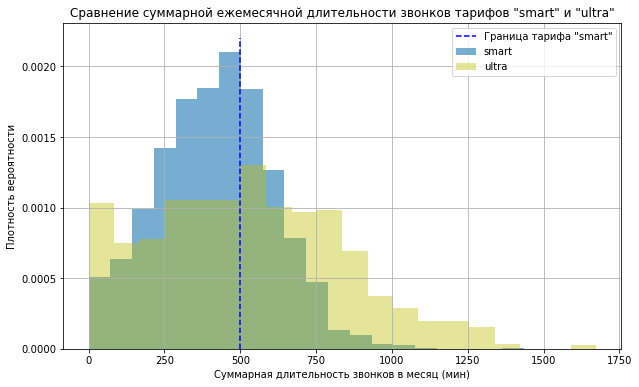

In [23]:
plt.vlines(x=500, ymin=0, ymax=0.0022, color='b', linestyle='dashed', label='Граница тарифа "smart"')
smart['calls_duration'].plot(kind='hist', bins=20, label='smart', alpha=0.6, density=True)

(
    ultra['calls_duration'].plot(kind='hist', bins=20, label='ultra', alpha=0.4, density=True,
                                 color='y', grid=True, figsize=(10, 6))
)
plt.legend()
plt.title('Сравнение суммарной ежемесячной длительности звонков тарифов "smart" и "ultra"')
plt.ylabel('Плотность вероятности')
plt.xlabel('Суммарная длительность звонков в месяц (мин)')
plt.show()

Как из гистограмм, так и из полученых дисперсий заметно, что для тарифа "ultra" разброс и разнообразие значений выше чем у тарифа "smart".

Также по падению значений после границы тарифа "smart" видно, что чаще всего после использования пакета минут пользователи тарифа "smart" начинают воздерживаться от долгих звонков. Для пользователей тарифа "ultra" их граничное значение (3000 мин) оказалось недостижимым, поэтому они, по сути, пользуются звонками без ограничений. Поэтому для них среднее несколько выше, чем для пользователей тарифа "smart".

Кроме того, по некоторой причине доля клиентов "ultra", которые не пользуются звонками вовсе (или очень мало ими пользуются) больше чем для тарифа "smart".

## Сообщения

**Smart**

In [24]:
print('Среднее количество =', smart['messages_count'].mean())
print('Дисперсия =', smart['messages_count'].var())
print('Стандартное отклонение =', smart['messages_count'].std())

Среднее количество = 33.384028712427096
Дисперсия = 796.8129584480083
Стандартное отклонение = 28.22787555676141


**Ultra**

In [25]:
print('Среднее количество =', ultra['messages_count'].mean())
print('Дисперсия =', ultra['messages_count'].var())
print('Стандартное отклонение =', ultra['messages_count'].std())

Среднее количество = 49.36345177664975
Дисперсия = 2285.2661425446836
Стандартное отклонение = 47.80445735017482


**Сравнение**

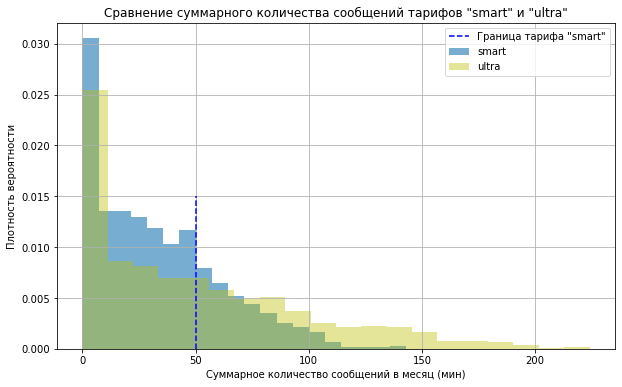

In [26]:
plt.vlines(x=50, ymin=0, ymax=0.015, color='b', linestyle='dashed', label='Граница тарифа "smart"')
smart['messages_count'].plot(kind='hist', bins=20, label='smart', alpha=0.6, density=True)

(
    ultra['messages_count'].plot(kind='hist', bins=20, label='ultra', alpha=0.4, density=True,
                                 color='y', grid=True, figsize=(10, 6))
)
plt.legend()
plt.title('Сравнение суммарного количества сообщений тарифов "smart" и "ultra"')
plt.ylabel('Плотность вероятности')
plt.xlabel('Суммарное количество сообщений в месяц (мин)')
plt.show()

Вновь как по дисперсии так и по самим гистограммам видно, что разнообразие количества сообщений для пользователей "ultra" несколько шире, чем для пользователей "smart".

И вновь видно как количество отравленных сообщений постепенно падает для пользователей "smart" после достижения границы. Поэтому среднее количество отправленных сообщений пользователей тарифа "ultra" несколько выше.

Тем не менее среди пользователей обоих тарифов велика доля тех кто почти или вовсе не пользуется сообщениями.

## Интернет-трафик

**Smart**

In [27]:
print('Среднее количество =', smart['gb_used'].mean())
print('Дисперсия =', smart['gb_used'].var())
print('Стандартное отклонение =', smart['gb_used'].std())

Среднее количество = 16.328847016599372
Дисперсия = 33.02870517811158
Стандартное отклонение = 5.747060568509052


**Ultra**

In [28]:
print('Среднее количество =', ultra['gb_used'].mean())
print('Дисперсия =', ultra['gb_used'].var())
print('Стандартное отклонение =', ultra['gb_used'].std())

Среднее количество = 19.494416243654822
Дисперсия = 97.09168626965469
Стандартное отклонение = 9.853511367510299


**Сравнение**

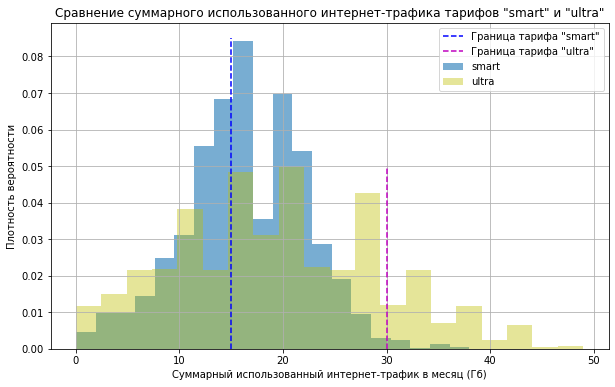

In [29]:
plt.vlines(x=15, ymin=0, ymax=0.085, color='b', linestyle='dashed', label='Граница тарифа "smart"')
plt.vlines(x=30, ymin=0, ymax=0.05, color='m', linestyle='dashed', label='Граница тарифа "ultra"')
smart['gb_used'].plot(kind='hist', bins=20, label='smart', alpha=0.6, density=True)

(
    ultra['gb_used'].plot(kind='hist', bins=20, label='ultra', alpha=0.4, density=True,
                                 color='y', grid=True, figsize=(10, 6))
)
plt.legend()
plt.title('Сравнение суммарного использованного интернет-трафика тарифов "smart" и "ultra"')
plt.ylabel('Плотность вероятности')
plt.xlabel('Суммарный использованный интернет-трафик в месяц (Гб)')
plt.show()

Эти гистограммы выглядят более пестро чем предыдущие, тем не менее по-прежнему как дисперсия так и внешний вид гистограммы указывают на более широкое распределение для тарифа "ultra", чем для "smart".

В этот раз видно, что хоть пользователи тарифа "smart" стараются держаться ближе к границе своего тарифа, все же они довольно часто её переходят, и продолжают пользоваться интернетом, несмотря на исчерпание пакета интернет-трафика.

Более того, даже пользователи тарифа "ultra" порой исчерпывают свой пакет гигабайт, и, несмотря на это, продолжают пользоваться интернетом. Хотя это и происходит значительно реже чем для пользователей "smart". В среднем пользователи "ultra" ислоьзуют больше интернет трафика, чем пользователи "smart".

Из всего этого видно, что изначального пакета интернета для пользователей обоих тарифов бывает недостаточно.

# Проверка гипотез
## Гипотеза о различии выручек с тарифов
Средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается.

Сформулируем нулевую гипотезу: Средняя выручка с пользователей тарифов «Ультра» и «Смарт» одинакова.

Альтернативная гипотеза: Средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается.

Пороговым значением p-критерия значимости будет значение в 0.05.

In [30]:
ser_tariff = total_usage.reset_index().groupby(['user_id', 'tariff'])['proceeds'].mean()
ser_smart = ser_tariff.loc[(slice(None), 'smart')]
ser_ultra = ser_tariff.loc[(slice(None), 'ultra')]

Для начала посмотрим на распределение средних месячных выручек с клиента для этих тарифов.

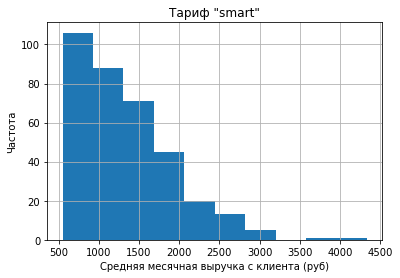

In [31]:
ser_smart.hist()
plt.title('Тариф "smart"')
plt.ylabel('Частота')
plt.xlabel('Средняя месячная выручка с клиента (руб)')
plt.show()

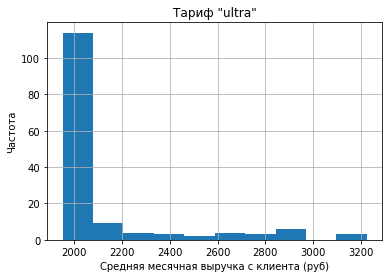

In [32]:
ser_ultra.hist()
plt.title('Тариф "ultra"')
plt.ylabel('Частота')
plt.xlabel('Средняя месячная выручка с клиента (руб)')
plt.show()

Эти распределения не очень похожи на нормальные. Поэтому для сравнения их дисперсий воспользуемся тестом Левена.

Нулевая гипотеза для теста Левена: Дисперсии генеральных совокупностей для распределений выручек тарифов "smart" и "ultra" равны. Пороговым значением критерия значимости назначим значение 0.05.

In [33]:
levene = st.levene(ser_smart, ser_ultra)
print('Дисперсия средних месячных выручек тарифа "smart" =', ser_smart.var())
print('Дисперсия средних месячных выручек тарифа "ultra" =', ser_ultra.var())
print('p-значение критерия Левена =', levene.pvalue)

Дисперсия средних месячных выручек тарифа "smart" = 367285.1500142482
Дисперсия средних месячных выручек тарифа "ultra" = 89121.78498148198
p-значение критерия Левена = 1.5891478588670946e-18


Поскольку p-значение критерия Левена = 1.5891478588670946e-18 значительно меньше 0.05, отвергнем нулевую гипотезу в пользу гипотезы о том, что дисперсии генеральных совокупностей различны. А значит для сравнения средних выручек воспользуемся t-критерием Уэлча.

In [34]:
results = st.ttest_ind(ser_smart, ser_ultra, equal_var=False)
print('Средняя выручка для тарифа "smart" =', ser_smart.mean())
print('Средняя выручка для тарифа "ultra" =', ser_ultra.mean())
print('p-значение t-критерия Уэлча =' ,results.pvalue)

Средняя выручка для тарифа "smart" = 1324.4010192743758
Средняя выручка для тарифа "ultra" = 2086.4646586521594
p-значение t-критерия Уэлча = 2.084961899583595e-59


Полученное p-значенние значительно меньше порогового 0.05. А значит примем альтернативную гипотезу о том, что средняя выручка с разных тарифов различна.

## Гипотеза о различии выручек с в Москве и других регионах
Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформулируем нулевую гипотезу: Средняя выручка с пользователей из Москвы и с ползователей из регионов одинакова.

Альтернативная гипотеза: Средняя выручка с пользователей из Москвы и с ползователей из регионов различается.

Пороговым значением p-критерия значимости будет значение в 0.05. Пойдем по алгоритму проверки схожему с проверкой предыдущей гипотезы.

In [35]:
ser_city = total_usage.copy()
ser_city['city'].where(ser_city['city'] == 'Москва', 'не Москва', inplace=True)
ser_city = ser_city.reset_index().groupby(['user_id', 'city'])['proceeds'].mean()
ser_moscow = ser_city.loc[(slice(None), 'Москва')]
ser_not_moscow = ser_city.loc[(slice(None), 'не Москва')]

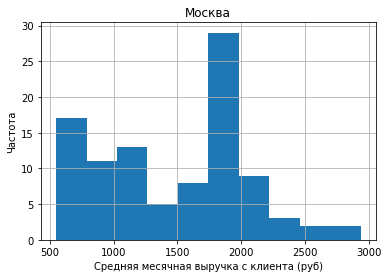

In [36]:
ser_moscow.hist()
plt.title('Москва')
plt.ylabel('Частота')
plt.xlabel('Средняя месячная выручка с клиента (руб)')
plt.show()

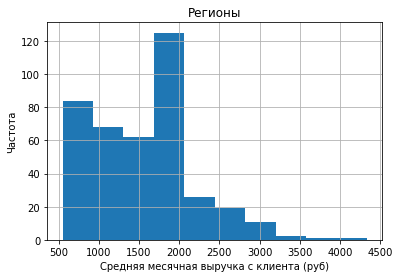

In [37]:
ser_not_moscow.hist()
plt.title('Регионы')
plt.ylabel('Частота')
plt.xlabel('Средняя месячная выручка с клиента (руб)')
plt.show()

Распределения непохожи на нормальные, применим тест Левена. Пороговым значением критерия значимости назначим значение 0.05.

In [38]:
levene = st.levene(ser_moscow, ser_not_moscow)
print('Дисперсия средних месячных выручек с пользователей из Москвы =', ser_moscow.var())
print('Дисперсия средних месячных выручек с пользователей из регионов =', ser_not_moscow.var())
print('p-значение критерия Левена =', levene.pvalue)

Дисперсия средних месячных выручек с пользователей из Москвы = 367815.3267880204
Дисперсия средних месячных выручек с пользователей из регионов = 415337.8863947992
p-значение критерия Левена = 0.9512125221472596


Что больше 0.05. Гипотезу от том, что дисперсии генеральных совокупностей одинаковы не отвергаем. Значит проверку различия средних будем проводить стандартным t-тестом для независимых выборок.

In [39]:
results = st.ttest_ind(ser_moscow, ser_not_moscow)
print('Средняя выручка с пользователей из Москвы =', ser_moscow.mean())
print('Средняя выручка с пользователей из регионов =', ser_not_moscow.mean())
print('p-значение t-критерия =' ,results.pvalue)

Средняя выручка с пользователей из Москвы = 1498.465851152215
Средняя выручка с пользователей из регионов = 1563.8822229636137
p-значение t-критерия = 0.36094633224451433


Что вновь больше чем 0.05. Значит не отвергаем нулевую гипотезу о том, что средняя выручка с пользователей из Москвы и с пользователей из регионов одинакова.

# Выводы
1. Средняя выручка для тарифа "smart" = 1324 руб, средняя выручка для тарифа "ultra" = 2086 руб для данной выборки. Различие признано статистически значимым. Значит продвижение тарифа "ultra" является более выгодным.
2. Гипотеза о различии средних выручек с клиентов из Москвы и с клиентов из регионов себя не оправдала. Они приносят примерно одинаковый доход.